# Machine Learning Programming Exercise 4: Neural Network Learning

In [1]:
#import package(s)
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import scipy.io as sio 
import math
import numpy.linalg 

## 1 Neural Network
This part of the exercise uses neural networks to recognize handwritten digits (from $0$ to $9$). The neural network will be able to represent complex models that form nonlinear hypotheses. The backpropagation algorithm will be implemented for neural networks to learn the parameters and apply it to the task of hand-written digit recognition.

### 1.1 Dataset
The file ex3data1.mat contains 5000 training examples from the MNIST handwritten digit dataset. Each training example is a 20 pixel by 20 pixel grayscale image of the digit. Every row of the feature matrix $X$ is a training example for a handwritten digit image.

The 5000-dimensional vector $y$ contains labels for the training set. Due to indexing, the digit zero is mapped to the value ten while the other digits are mapped as normal. That is, a "$0$" digit is labeled as "$10$".

In [2]:
#Setup the parameters you will use for this part of the exercise

#20x20 Input Images of Digits
input_layer_size  = 400  

#25 hidden units
hidden_layer_size = 25   

#10 labels, from 1 to 10 (note that we have mapped "0" to label 10)
num_labels = 10       

### 1.2 Visualizing the data
A subset of the training set is visualized by randomly selecting 100 rows from the matrix $X$ and passes those rows to the displayData function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together.

Loading and Visualizing Data ...



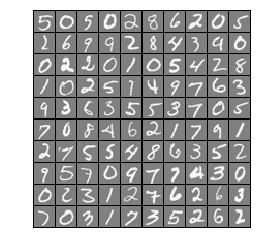

In [3]:
#define function for exercise(s)
def displayData(X):
#DISPLAYDATA Display 2D data in a nice grid
    example_width = int(round(math.sqrt(X.shape[1])))

    # Compute rows, cols
    m,n = X.shape
    example_height = int(n / example_width)

    # Compute number of items to display
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))

    # Between images padding
    pad = 1

    # Setup blank display
    row_initial = pad + display_rows*(example_height + pad)
    col_initial = pad + display_cols*(example_width + pad)
    display_array = -(np.ones((row_initial, col_initial)))

    # Copy each example into a patch on the display array
    curr_ex = 0
    for j  in range(display_rows):
        for i in range(display_cols):
            if curr_ex > m:
                break 
            # Copy the patch
            
            # Get the max value of the patch
            max_val = max(abs(X[curr_ex, :]))
            
            row_arr = list(map(lambda x:x+pad+j*(example_height + pad), range(example_height+1)))
            col_arr = list(map(lambda x:x+pad+i*(example_width + pad), range(example_width+1)))
            display_array[row_arr[0]:row_arr[-1], col_arr[0]:col_arr[-1]] = np.reshape(X[curr_ex, :], (example_height, example_width)) / max_val
            curr_ex = curr_ex + 1
            
        if curr_ex > m:
            break
    # Display Image
    h = plt.imshow(display_array.T, clim = (-1,1))
    # gray scale the image
    h.set_cmap('gray')
    # Do not show axis
    plt.axis('off')
    plt.show()

# =========== Part 1: Loading and Visualizing Data =============
#  We start the exercise by first loading and visualizing the dataset.
#  You will be working with a dataset that contains handwritten digits.

#Loading and Visualizing Data 
print('Loading and Visualizing Data ...\n')
data = sio.loadmat('ex4data1.mat')
#training data stored in the arrays X, y
X = data['X']
y = data['y']

#m is the number of rows of X
m = X.shape[0]

#Randomly select 100 data points to display
rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100], :]

displayData(sel)

### 1.3 Model representation
The model for the neural network will have three layers: an input layer, a hidden layer and an output layer. 

The input layer is the inputs or features for the model, which are pixel values of digit images. Since the images are of size $20\times20$, this gives $400$ input layer units (excluding the extra bias unit, $x_0$, which always output $+1$). 

The hidden layer is between the input an output layer. In this layer, the activation units are computed. 

The output layer is the outputs or results of the hypothesis function, which is the digits from $1$ to $10$. The sigmoid (logistic) function is used and is often called the sigmoid activiation function. 

Image source: ex3.pdf from Andrew Ng's Coursera course in Machine Learning
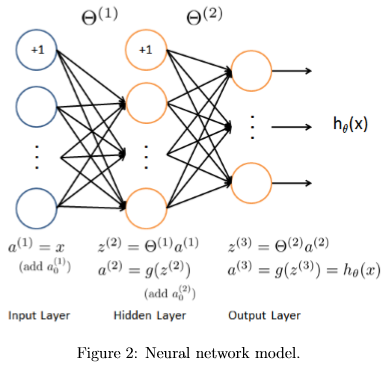

The set of trained parameters $(\Theta^{(1)}, \Theta^{(2)})$ are given. $\Theta^{(1)}$ is of size $25\times401$ for the $25$ activation units in the second layer and the $400$ input units plus the bias unit in the input layer. $\Theta^{(2)}$ is of size $10\times26$ for the $10$ units in the output layer and the $25$ activation units plus the bias unit in the hidden layer. 

Recall, the vector representation of $x$ and $z^j$ for layer $j$ and $n$ units is
$x = \begin{bmatrix}
       x_0 \\
       x_1 \\
       \vdots \\
       x_{n}
       \end{bmatrix}, \quad z^{(j)} = \begin{bmatrix}
       z_1^{(j)} \\
       z_2^{(j)} \\
       \vdots \\
       z_{n}^{(j)}
       \end{bmatrix}$,
where 
$z_k^{(j)} = \Theta_{k,0}^{(j-1)} x_0 + \Theta_{k,1}^{(j-1)} x_1 + \dots + \Theta_{k,n}^{(j-1)} x_n$ for layer $j$ and node $k$.

<div class="alert alert-block alert-info">
<b>Implementation Note:</b>  
In neural networks, these sets of parameters and accumulator matrices, 
   $\Theta^{(1)}, \Theta^{(2)}, \Theta^{(3)}, \dots$
   $D^{(1)}, D^{(2)}, D^{(3)}, \dots $, are unrolled into one long vectors. This allow us to use advanced optimization algorithms as those algorithms tend to assume that you have all of your parameters unrolled into a big long vector.
   
   The original matrices are still used for the matrix computations in the forward propagation and backward propagation algorithms.
</div>

In [4]:
# ================ Part 2: Loading Parameters ================
# In this part of the exercise, we load some pre-initialized 
# neural network parameters.

print('Loading Saved Neural Network Parameters ...\n')

#Load the weights into variables Theta1 and Theta2
wts = sio.loadmat('ex4weights.mat')
T1 = wts['Theta1']
T2 = wts['Theta2']

#Unroll parameters 
nn_params = np.vstack((T1.T.reshape((-1,1)),T2.T.reshape((-1,1)))) 

Loading Saved Neural Network Parameters ...



### 1.4 Feedforward and cost function

Recall that the cost function for the neural network (without regularization) is
$\begin{align*} J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K \left [ -y_k^{(i)} \log((h_{\theta} (x^{(i)}))_k) - (1-y_k^{(i)}) \log(1-(h_{\theta} (x^{(i)}))_k) \right] \end{align*}$. Here, $K=10$ for the total number of possible labels. Note that $h_{\theta} (x^{(i)})_k = a_k^{(3)}$ is the activation (output value) of the $k$th output unit.

Recall that the original labels for $y$ were $1, 2, \dots, 10$. For the purpose of training a neural network, the labels are recoded as vectors containing only values $0$ or $1$, similar to one-hot encoding.

$y = \begin{bmatrix}
       1 \\
       0 \\
       \vdots \\
       0
       \end{bmatrix}, \quad  \begin{bmatrix}
       0 \\
       1 \\
       \vdots \\
       0
       \end{bmatrix}, \quad \dots  \quad \text{or} \quad \begin{bmatrix}
       0 \\
       0 \\
       \vdots \\
       1
       \end{bmatrix}$
       
 For example, if $x^{(i)}$ is an image of the digit $5$, then the corresponding $y^{(i)}$ should be a $10$-dimensional vector with $y_5=1$ and all of the other elements equal to $0$. The feedforward computation computes $h_{\theta}(x^{(i)})$ for every example $i$ and sum the cost over all examples.
 
 Essentially, for forward propagation, the inputs are passed through the neural network to calculate the output of the model, which is a prediction of the digit handwritten in the image.

<div class="alert alert-block alert-info">
<b>Note:</b>  
The setup looks like this:
    $x = \begin{bmatrix}
       x_0 \\
       x_1 \\
       \vdots \\
       x_{400}
       \end{bmatrix} \to \begin{bmatrix}
       a_0^{(2)} \\
       a_1^{(2)} \\
       \vdots \\
       a_{25}^{(2)}
       \end{bmatrix} \to \begin{bmatrix}
       (h_{\theta}(x))_{1} \\
       (h_{\theta}(x))_{2} \\
       \vdots \\
       (h_{\theta}(x))_{10}
       \end{bmatrix} $.
</div>

The cost should be about $0.287629$.

<div class="alert alert-block alert-info">
<b>Implementation Note:</b>  
Add a column of ones to the matrices for the bias unit. The matrices Theta1 and Theta2 contain the parameters for each unit in rows. Transpose these matrices when necessary for the matrix calculations. 
 
The code should also work for a dataset of any size, with any number of labels (assume that there are at least $K \geq 3$ labels. 
</div>


In [5]:
#define function for exercise(s)
def sigmoid(z):
#SIGMOID Compute sigmoid function
#   g = SIGMOID(z) computes the sigmoid of z.
    g = 1/(1 + np.exp(-z))
    return g

def lab2vec(num_labels, y):
#convert the labels into vectors like one-hot encoding   
    m = y.shape[0]
    Y = np.zeros((m, num_labels))
    for i in range(1, num_labels+1):
        for j in range(m):
            if y[j] == i:
                Y[j,i-1] = 1
                
    return np.matrix(Y)
    
def forward_prop(X, theta1, theta2):
#FORWARD_PROP forward propagation algorithm
    #Useful values
    m = X.shape[0]
    #Add ones to the X data matrix
    X = np.column_stack((np.ones((m,1)), X))
    #calculate the hidden units in layer 2 of the neural network
    a1 = X
    z2 = np.matrix(a1)*np.matrix(theta1.T)
    a2 = sigmoid(z2)
    a2 = np.column_stack((np.ones((m,1)), a2))
    z3 = np.matrix(a2)*np.matrix(theta2.T)
    h = sigmoid(z3)
    return a1, z2, a2, z3, h

def regparam(Theta):
#REGPARAM regularized term for regularized cost function
    param_squared = np.power(Theta[:,1:Theta.shape[1]],2)
    sum_param = param_squared.sum()
    return sum_param

def nnRegCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, 
                                   X, y, learningRate):  
#NNREGCOSTFUNCTION Implements the neural network cost function for a two layer neural network which performs classification

    #Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices for our 2 layer neural network
    Theta1 = nn_params[0:hidden_layer_size*(input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1, order='F')
    Theta2 = nn_params[hidden_layer_size*(input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1, order='F')
    
    #Setup some useful variables
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    Theta1 = np.matrix(Theta1)
    Theta2 = np.matrix(Theta2)
    
    #use forward propagation to get the hypothesis function
    a1, z2, a2, z3, h = forward_prop(X, Theta1, Theta2)
    Y = lab2vec(num_labels, y)
    
    #compute the cost
    #initialize J to be a vector to find the cost for each of the labels 
    J = np.zeros((num_labels))
    
    #iterate through the k labels (columns)
    for i in range(num_labels):
        first = np.multiply(-Y[:,i], np.log(h[:,i]))
        second = np.multiply((1 - Y[:,i]), np.log(1 - h[:,i]))
        #find the average over m training examples
        J[i] = (first - second).mean()
    
    #sum over k labels
    J = np.sum(J)
    
    #regularize parameters
    reg_theta1 = regparam(Theta1)
    reg_theta2 = regparam(Theta2)
    
    reg = (learningRate*(reg_theta1 + reg_theta2))/float(2*m)
    
    return J + reg

# ================ Part 3: Compute Cost (Feedforward) ================
#  To the neural network, you should first start by implementing the
#  feedforward part of the neural network that returns the cost only. You
#  should complete the code in nnCostFunction.m to return cost. After
#  implementing the feedforward to compute the cost, you can verify that
#  your implementation is correct by verifying that you get the same cost
#  as us for the fixed debugging parameters.

#  We suggest implementing the feedforward cost *without* regularization
#  first so that it will be easier for you to debug. Later, in part 4, you
#  will get to implement the regularized cost.

print('Feedforward Using Neural Network ...\n')

#Weight regularization parameter (we set this to 0 here).
Lambda = 0

J = nnRegCostFunction(nn_params, input_layer_size, hidden_layer_size, 
                   num_labels, X, y, Lambda)

print('Cost at parameters (loaded from ex4weights):', J)
print('This value should be about 0.287629')

Feedforward Using Neural Network ...

Cost at parameters (loaded from ex4weights): 0.2876291651613189
This value should be about 0.287629


### 1.5 Regularized cost function
The cost function for a neural network with regularization is 
$\begin{align*} J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K \left [ -y_k^{(i)} \log((h_{\theta} (x^{(i)}))_k) - (1-y_k^{(i)}) \log(1-(h_{\theta} (x^{(i)}))_k) \right] + \frac{\lambda}{2m} \left [ \sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 +  \sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta_{j,k}^{(2)})^2  \right ] \end{align*}$.
The equation above assumes the neural network only has 3 layers – an input layer, a hidden layer and an output layer. However, the code should work for any number of input units, hidden units and outputs units. In addition, the indices above for $\Theta^{(1)}$ and $\Theta^{(2)}$ were explicitly listed, but in general they can be of any size. The bias term are not regularized. 

For $\lambda = 1$, the cost should be about $0.383770$.

<div class="alert alert-block alert-info">
<b>Note:</b>  
In general, the cost function for a neural network with regularization looks like
    $\begin{align*} J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K \left [ -y_k^{(i)} \log((h_{\theta} (x^{(i)}))_k) - (1-y_k^{(i)}) \log(1-(h_{\theta} (x^{(i)}))_k) \right] + \frac{\lambda}{2m} \left [ \sum_{j=1}^{L-1} \sum_{k=1}^{s_j} \sum_{\ell=1}^{s_{j +1}}(\Theta_{k,\ell}^{(j)})^2   \right ] \end{align*}$ where $L$ is total number of layers, $s_j$ is the number of units in layer $j$, and $s_{j+1}$ is the number of units in layer $j+1$.
    
The double sum simply adds up the logistic regression costs calculated for each cell in the output layer. 

The triple sum simply adds up the squares of all the individual $\Theta$s in the entire network. The number of columns in our current theta matrix is equal to the number of nodes in our current layer (including the bias unit). The number of rows in our current theta matrix is equal to the number of nodes in the next layer (excluding the bias unit).
</div>

In [6]:
# =============== Part 4: Implement Regularization ===============
#  Once your cost function implementation is correct, you should now
#  continue to implement the regularization with the cost.

print('\nChecking Cost Function (w/ Regularization) ... \n')

#Weight regularization parameter (we set this to 1 here).
Lambda = 1

Jreg = nnRegCostFunction(nn_params, input_layer_size, hidden_layer_size, 
                         num_labels, X, y, Lambda)
print('Cost at parameters (loaded from ex4weights):', Jreg)
print('This value should be about 0.383770')


Checking Cost Function (w/ Regularization) ... 

Cost at parameters (loaded from ex4weights): 0.38376985909092365
This value should be about 0.383770


## 2 Backpropagation
The backpropagation algorithm is used to compute the gradient for the neural network cost function. Once the gradient is computed, the neural network is trained by minimizing the cost function $J(\theta)$ with an advanced optimizer. Doing so will allow the neural network to improve its accuracy by updating the weights based on the node responsible for the most error.

**Backpropagation Intuition**

Consider a simple non-multiclass classiﬁcation ($k = 1$) without regularization ($\lambda=0$), then the cost is computed with
$\begin{align*} \text{cost}(t) = y^{(t)} \log(h_{\theta} (x^{(t)})) + (1-y^{(t)}) \log(1-h_{\theta} (x^{(t)})) \end{align*}$. The cost$(i)$ measures how well is the network correctly predicting example $i$.

The $\delta_j^{(\ell)}$ is the "error" for $a_j^{(\ell)}$ (unit $j$ in layer $\ell$). More formally, the delta values are actually the derivative of the cost function.

### 2.1 Sigmoid gradient
The gradient for the sigmoid function can be computed as
$\begin{align*} g'(z) = \frac{d}{dz} g(z) = g(z) (1-g(z)) \end{align*}$ where $\begin{align*}\text{sigmoid}(z) = g(z) = \frac{1}{1+e^{-z}}\end{align*}$. 

For large values (both positive and negative) of $z$, the gradient should be close to $0$. When $z = 0$, the gradient should be exactly $0.25$. The code should also work with vectors and matrices. For a matrix, the function should perform the sigmoid gradient function on every element.

The sigmoid gradient will be used to calculate the $\delta$ terms for backpropagation.

In [7]:
#define function for exercise(s)
def sigmoidGradient(z):
#SIGMOIDGRADIENT returns the gradient of the sigmoid function
#evaluated at z
#   g = SIGMOIDGRADIENT(z) computes the gradient of the sigmoid function
#   evaluated at z. This should work regardless if z is a matrix or a
#   vector. In particular, if z is a vector or matrix, you should return
#   the gradient for each element.

    G = sigmoid(np.matrix(z))
    return np.multiply(G,1-G)

# ================ Part 5: Sigmoid Gradient  ================
#  Before you start implementing the neural network, you will first
#  implement the gradient for the sigmoid function. You should complete the
#  code in the sigmoidGradient.m file.

print('Evaluating sigmoid gradient...\n')

g = sigmoidGradient(np.array([-1, -0.5, 0, 0.5, 1]))
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: \n', g)

Evaluating sigmoid gradient...

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]: 
 [[0.19661193 0.23500371 0.25       0.23500371 0.19661193]]


### 2.2 Random initialization
When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(\ell)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$. This range of values ensures that the parameters are kept small and makes the learning more efficient.

One eﬀective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network: $\begin{align*} \epsilon_{init} =  \frac{\sqrt{6}}{\sqrt{s_{\ell} + s_{\ell + 1}}}\end{align*}$, where $s_{\ell}$ and $s_{\ell + 1}$ are the number of units in the layers adjacent to $\Theta^{(\ell)}$.

Initializing all theta weights to zero does not work with neural networks. When we backpropagate, all nodes will update to the same value repeatedly. That is, all of the hidden units are computing the exact same function of the input. And this is a highly redundant representation because you ﬁnd the logistic progression unit. It really has to see only one feature because all of these are the same. This prevents the network from doing something interesting.

In [8]:
#define function for exercise(s)
def randInitializeWeights(L_in, L_out):
#RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
#incoming connections and L_out outgoing connections
#   W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights 
#   of a layer with L_in incoming connections and L_out outgoing 
#   connections. 
#   Note that W should be set to a matrix of size(L_out, 1 + L_in) as
#   the first column of W handles the "bias" terms

    # Randomly initialize the weights to small values
    epsilon_init = 0.12
    #Generate a matrix of uniformly distributed numbers 
    #in the interval [-epsilon init, epsilon init]
    W = ((np.random.rand(L_out, 1 + L_in))*2*epsilon_init) - epsilon_init
    #In general, you can generate N random numbers in the interval (a,b) 
    #with the formula r = a + (b-a)*np.random.rand(N,1).
    return W

# ================ Part 6: Initializing Pameters ================
#  In this part of the exercise, you will be starting to implment a two
#  layer neural network that classifies digits. You will start by
#  implementing a function to initialize the weights of the neural network
#  (randInitializeWeights.m)

print('Initializing Neural Network Parameters ...\n')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

#Unroll parameters
initial_nn_params = np.vstack((initial_Theta1.T.reshape((-1,1)),initial_Theta2.T.reshape((-1,1))))

Initializing Neural Network Parameters ...



### 2.3 Backpropagation
**Backpropagation Algorithm Intuition**

Given a training example $(x^{(t)}, y^{(t)})$, run forward propagation to compute all the activations throughout the network, including the output value of the hypothesis $h_{\theta} (x)$. Then, for each node $j$ in layer $\ell$, compute an "error term" $\delta_j^{(\ell)}$ to measure how much that node was "responsible" for any errors in the output. 

For an output node, compute $\delta_j^{(3)}$ to measure the diﬀerence between the network’s activation and the true target value (since layer $3$ is the output layer). For the hidden units, compute $\delta_j^{(\ell)}$ based on a weighted average of the error terms of the nodes in layer $\ell + 1$.

Image source: ex4.pdf from Andrew Ng's Coursera course in Machine Learning
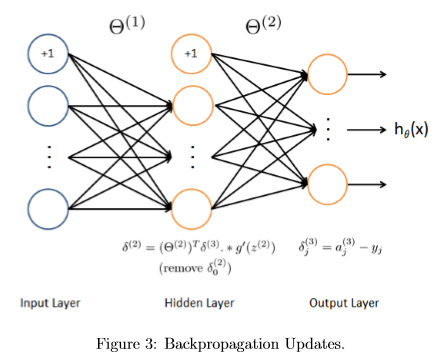

**Backpropagation Algorithm**

Implement steps $1$ to $4$ in a loop that processes one example at a time with the $t$th iteration performing the calculation on the $t$th training example $(x^{(t)}, y^{(t)})$.
1. Set the input layer’s value ($a^{(\ell)}$) to the $t$th training example $x^{(t)}$. Perform forward propagation to compute vectors of activation units $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ in layers $2$ and $3$. Include the bias unit for $a^{(2)}$ and $a^{(3)}$.  

  a. In general, forward propagation is used to compute $a^{(\ell)}$ for $\ell = 2, 3, \dots, L$, where $L$ is the last layer.

2. For each output unit $k$ in layer $3$ (the output layer), compute $\begin{align*} \delta_k^{(3)}=  a_k^{(3)} - y_k \end{align*}$ where $y_k$ indicates whether the current training example belongs to class $k (y_k = 1)$, or if it belongs to a diﬀerent class $(y_k = 0)$. The "error values" for the last layer are simply the diﬀerences of our actual results in the last layer and the correct outputs in $y$.
3. For the hidden layer $\ell = 2$, set $\begin{align*} \delta^{(2)}= \left  (\Theta^{(2)} \right)^T \delta^{(3)}. \ast g'(z^{(2)}) \end{align*}$. This step involves backpropagating the errors, starting from the output layer to the layers before it. There isn't a $\delta^{(1)}$ because we don’t associate an error term with the input layer.

  a. In general, back propagation is used to compute $\delta^{(L-1)}, \delta^{(L-2)}, \dots, \delta^{(2)}$ where $\begin{align*} \delta^{(\ell)}= \left ( \left (\Theta^{(\ell)} \right)^T \delta^{(\ell + 1)} \right). \ast a^{(\ell)}. \ast \left ( 1-a^{(\ell)} \right) \end{align*}$.

4. Accumulate the gradients with the formula, $\begin{align*} \Delta^{(\ell)} = \Delta^{(\ell)} + \delta^{(\ell + 1)} \left ( a^{(\ell)} \right)^T  \end{align*}$.
5. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}: \begin{align*} \frac{\partial}{\partial \Theta_{ij}^{(\ell)}} J(\Theta) = D_{ij}^{(\ell)} = \frac{1}{m} \Delta_{ij}^{(\ell)}\end{align*}$.
  
<div class="alert alert-block alert-info">
<b>Implementation Note:</b>  
Implement the backpropagation algorithm only after the feedforward and cost functions have been successfully completed. 

Print the sizes of the variables, using something like the shape function, to help debug dimensions mismatch errors. 
</div>

After implementing the backpropagation algorithm, run gradient checking to ensure the code is computing the gradients correctly.

In [9]:
#define function for exercise(s)
def debugInitializeWeights(fan_out, fan_in):
#DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
#incoming connections and fan_out outgoing connections using a fixed
#strategy, this will help you later in debugging
#   W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights 
#   of a layer with fan_in incoming connections and fan_out outgoing 
#   connections using a fix set of values

#  Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
#   the first row of W handles the "bias" terms    
    
    # Set W to zeros
    W = np.zeros((fan_out, 1 + fan_in))
    
    # Initialize W using "sin", this ensures that W is always of the same
    # values and will be useful for debugging
    W = ((np.sin(np.array(range(1,W.size+1)))).reshape((W.shape[0], W.shape[1])))/float(10)
    return W

def computeNumericalGradient(theta, input_layer_size, hidden_layer_size, num_labels, 
                             X, y, learningRate):
#COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
#and gives us a numerical estimate of the gradient.
#   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
#   gradient of the function J around theta. Calling y = J(theta) should
#   return the function value at theta.

    numgrad = np.zeros((theta.shape[0],theta.shape[1]))
    perturb = np.zeros((theta.shape[0],theta.shape[1]))
    e = 1e-4
    
    for p in range(0,theta.size):
        #Set perturbation vector
        #change one of elements of the vector to be the value of e
        perturb[p] = e
        #calculate the cost function at the perturb values for theta
        loss1 = nnRegCostFunction(theta - perturb, input_layer_size, 
                                  hidden_layer_size, num_labels, 
                                   X, y, learningRate)
        loss2 = nnRegCostFunction(theta + perturb, input_layer_size, 
                                  hidden_layer_size, num_labels, 
                                   X, y, learningRate)
        #Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / float(2*e)
        #change the element back to zero
        perturb[p] = 0
        
    return numgrad

def back_prop(nn_params, input_layer_size, hidden_layer_size, num_labels, 
                                   X, y, learningRate): 
#BACK_PROP Compute the backpropagation algorithm
    
    #Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    #for our 2 layer neural network
    Theta1 = nn_params[0:hidden_layer_size*(input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1, order='F')
    Theta2 = nn_params[hidden_layer_size*(input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1, order='F')
    
    #Setup some useful variables
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    Theta1 = np.matrix(Theta1)
    Theta2 = np.matrix(Theta2)
    
    Delta1 = np.zeros(Theta1.shape)  # (25, 401)
    Delta2 = np.zeros(Theta2.shape)  # (10, 26)
    
    #use forward propagation to get the hypothesis function
    a1, z2, a2, z3, h = forward_prop(X, Theta1, Theta2)
    Y = lab2vec(num_labels, y)
    
    for t in range(m):
        a1t = a1[t,:]  # (1, 401)
        z2t = z2[t,:]  # (1, 25)
        a2t = a2[t,:]  # (1, 26)
        ht = h[t,:]  # (1, 10)
        yt = Y[t,:]  # (1, 10)

        #error term in the output layer (layer 3)
        delta3 = ht - yt # (1, 10)
        
        #error term in layer 2
        z2t = np.column_stack((np.ones((1,1)), z2t)) # (1, 26)
        delta2 = np.multiply((Theta2.T * delta3.T).T, sigmoidGradient(z2t)) # (1, 26)
        
        Delta1 = Delta1 + (delta2[:,1:]).T * a1t # (25, 401)
        Delta2 = Delta2 + delta3.T * a2t # (10, 26)
    
    #accumulated gradients for j=0
    Delta1[:,0]  = Delta1[:,0] / float(m)
    Delta2[:,0]  = Delta2[:,0] / float(m)
    
    #accumulated gradients with regularization term (for j>0)
    Delta1[:,1:] = Delta1[:,1:] / float(m) + (Theta1[:,1:] * learningRate) / float(m)
    Delta2[:,1:] = Delta2[:,1:] / float(m) + (Theta2[:,1:] * learningRate) / float(m)
    
    #Unroll gradients
    grad = np.vstack((Delta1.T.reshape((-1,1)),Delta2.T.reshape((-1,1))))   
    
    #use for method = TNC
    #return grad
    
    #change G.shape from 2d to 1d for bgfs, cg, etc
    return np.ravel(grad)
    
def checkNNGradients(Lambda):
#CHECKNNGRADIENTS Creates a small neural network to check the
#backpropagation gradients
#   CHECKNNGRADIENTS(lambda) Creates a small neural network to check the
#   backpropagation gradients, it will output the analytical gradients
#   produced by your backprop code and the numerical gradients (computed
#   using computeNumericalGradient). These two gradient computations should
#   result in very similar values

    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1)
    y = (1 + np.array(range(1,m+1)) % num_labels).reshape((-1,1))
    
    # Unroll parameters
    nn_params = np.vstack((Theta1.T.reshape((-1,1)),Theta2.T.reshape((-1,1)))) 

    # numerical gradients
    numgrad = computeNumericalGradient(nn_params, input_layer_size, hidden_layer_size, 
                                       num_labels, X, y, Lambda)
    
    grad = back_prop(nn_params, input_layer_size, hidden_layer_size, num_labels, 
                                   X, y, Lambda)
    grad = np.reshape(grad, (-1,1))
    #transform grad back to a column vector to calculate the relative difference
    
    # Visually examine the two gradient computations.  The two columns
    # you get should be very similar. 
    print( np.column_stack((numgrad, grad)))
    print('\nThe above two columns you get should be very similar.')
    print('[Left-Your Numerical Gradient   Right-Analytical Gradient]')

    # Evaluate the norm of the difference between two solutions.  
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    # in computeNumericalGradient.m, then diff below should be less than 1e-9
    diff = numpy.linalg.norm(numgrad-grad)/(numpy.linalg.norm(numgrad+grad))
    #numpy.linalg.norm is the euclidean norm or 2-norm
    
    print('\nIf your backpropagation implementation is correct, then') 
    print('the relative difference will be small (less than 1e-9).')
    print('Relative Difference:', diff)

# =============== Part 7: Implement Backpropagation ===============
#  Once your cost matches up with ours, you should proceed to implement the
#  backpropagation algorithm for the neural network. You should add to the
#  code you've written in nnCostFunction.m to return the partial
#  derivatives of the parameters.

print('Checking Backpropagation... \n')

#Check gradients by running checkNNGradients
Lambda = 0
checkNNGradients(Lambda)

Checking Backpropagation... 

[[ 1.23162247e-02  1.23162247e-02]
 [ 3.92471368e-03  3.92471369e-03]
 [-8.08459407e-03 -8.08459407e-03]
 [-1.26669105e-02 -1.26669105e-02]
 [-5.59342546e-03 -5.59342547e-03]
 [ 1.73828185e-04  1.73828184e-04]
 [ 1.90101255e-04  1.90101252e-04]
 [ 3.13170601e-05  3.13170587e-05]
 [-1.56130211e-04 -1.56130210e-04]
 [-2.00036574e-04 -2.00036572e-04]
 [ 2.61455144e-04  2.61455144e-04]
 [ 2.22272332e-04  2.22272331e-04]
 [-2.17840324e-05 -2.17840341e-05]
 [-2.45506162e-04 -2.45506163e-04]
 [-2.43630223e-04 -2.43630220e-04]
 [ 1.08701450e-04  1.08701450e-04]
 [ 5.00872566e-05  5.00872547e-05]
 [-5.48569856e-05 -5.48569864e-05]
 [-1.09164879e-04 -1.09164881e-04]
 [-6.32313690e-05 -6.32313673e-05]
 [ 3.09347722e-01  3.09347722e-01]
 [ 1.08133003e-01  1.08133003e-01]
 [ 1.06270372e-01  1.06270372e-01]
 [ 1.61067138e-01  1.61067138e-01]
 [ 5.61633717e-02  5.61633717e-02]
 [ 5.57611045e-02  5.57611045e-02]
 [ 1.47036522e-01  1.47036522e-01]
 [ 5.19510542e-02  5.1951

### 2.4 Gradient checking
Gradient checking will assure that backpropagation works as intended by checking that it is outputting correct derivative values. We can approximate the derivative of our cost function with: $\begin{align*} \frac{\partial}{\partial \Theta} J(\Theta) = \frac{J(\Theta + \epsilon)- J(\Theta - \epsilon)}{2 \epsilon}\end{align*}$.
With multiple theta matrices, we can approximate the derivative with respect to $\Theta_i$ with: $\begin{align*} \frac{\partial}{\partial \Theta_i} J(\Theta) = \frac{J(\Theta_{1}, \dots, \Theta_i + \epsilon, \dots, \Theta_n)- J(\Theta_{1}, \dots, \Theta_i - \epsilon, \dots, \Theta_n)}{2 \epsilon}\end{align*}$. 


To perform gradient checking on your parameters, you can imagine "unrolling" the parameters $\Theta^{(1)}, \Theta^{(2)}$ into one long vector $\theta$ and think of the cost function as $J(\theta)$. Suppose the function $f_i (\theta)$ computes $\frac{\partial}{\partial \theta_i} J(\theta)$ and $\theta^{(i+)} = \theta + \begin{bmatrix}
       0 \\
       0 \\
       \vdots \\
       \epsilon \\
       \vdots \\
       0
       \end{bmatrix}, \quad \theta^{(i-)} = \theta - \begin{bmatrix}
       0 \\
       0 \\
       \vdots \\
       \epsilon \\
       \vdots \\
       0
       \end{bmatrix}$. So, $\theta^{(i+)}$ is the same as $\theta$ except its $i$th element has been incremented by $\epsilon$. Likewise, $\theta^{(i-)}$ is the same as $\theta$ except its $i$th element has been decreased by $\epsilon$.
Then, mumerically verify $f_i (\theta)$'s correctness by checking for each $i$ that $\begin{align*} \frac{\partial}{\partial \Theta_i} J(\Theta) = \frac{J(\theta^{(i+)})  - J(\theta^{(i-)})}{2 \epsilon}\end{align*}$. By assuming $\epsilon=10^{-4}$, usually the left- and right-hand sides of the equation will agree to at least $4$ signiﬁcant digits (and often many more).

Run the function checkNNGradients, if backpropagation is correct, then there should be a relative diﬀerence that is less than 1e-09.

<div class="alert alert-block alert-info">
<b>Practical Tips:</b>  
When performing gradient checking, it is much more efficient to use a small neural network with a relatively small number of input units and hidden units, thus having a relatively small number of parameters to evaluate. Turn oﬀ gradient checking before running the learning algorithm when it has been verified that the gradient computations are correct.

Gradient checking works for any function when the computing the cost and the gradient. Meaning that the function computeNumericalGradient can be used to check if the gradient implementations of the other exercises are correct. 
</div>

### 2.5 Regularized Neural Networks
After computing $\Delta_{ij}^{(\ell)}$ using backpropagation, add regularization using
$\begin{align*} \frac{\partial}{\partial \Theta_{ij}^{(\ell)} } J(\theta) = D_{ij}^{(\ell)} = \frac{1}{m}  \Delta_{ij}^{(\ell)}, \quad j=0  \end{align*}$ (corresponds to the bias term),
$\begin{align*}\frac{\partial}{\partial \Theta_{ij}^{(\ell)} } J(\theta) =  D_{ij}^{(\ell)} = \frac{1}{m} \left (\Delta_{ij}^{(\ell)} + \lambda \Theta_{ij}^{(\ell)} \right), \quad j \geq 1. \end{align*}$  

Do not regularize the ﬁrst column of $\Theta^{(\ell)}$, which is used for the bias term. In addition, for $\Theta_{ij}^{(\ell)}$, $i$ is indexed starting at $1$ and $j$ is indexed starting at $0$. That is, 
$\Theta_{ij}^{(\ell)} = \begin{bmatrix}
       \Theta_{10}^{(\ell)} & \Theta_{11}^{(\ell)} & \cdots \\
       \Theta_{20}^{(\ell)} & \Theta_{21}^{(\ell)} & \cdots \\
       \vdots & \vdots & \vdots 
       \end{bmatrix}$.

In [10]:
# =============== Part 8: Implement Regularization ===============
#  Once your backpropagation implementation is correct, you should now
#  continue to implement the regularization with the cost and gradient.

print('Checking Backpropagation (w/ Regularization) ... \n')

#Check gradients by running checkNNGradients
Lambda = 3
checkNNGradients(Lambda)

#Also output the costFunction debugging values
debug_J  = nnRegCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, Lambda)

print('Cost at (fixed) debugging parameters (w/ lambda = %s): %s' % (Lambda, debug_J))
print('\nFor lambda = 3, this value should be about 0.576051')

Checking Backpropagation (w/ Regularization) ... 

[[ 0.01231622  0.01231622]
 [ 0.00392471  0.00392471]
 [-0.00808459 -0.00808459]
 [-0.01266691 -0.01266691]
 [-0.00559343 -0.00559343]
 [ 0.05473167  0.05473167]
 [-0.01657483 -0.01657483]
 [-0.03260995 -0.03260995]
 [ 0.05928031  0.05928031]
 [-0.04525927 -0.04525927]
 [ 0.00872866  0.00872866]
 [ 0.03964147  0.03964147]
 [-0.0600212  -0.0600212 ]
 [ 0.03877176  0.03877176]
 [ 0.008749    0.008749  ]
 [-0.04529945 -0.04529945]
 [ 0.05941158  0.05941158]
 [-0.03224923 -0.03224923]
 [-0.01738336 -0.01738336]
 [ 0.05471348  0.05471348]
 [ 0.30934772  0.30934772]
 [ 0.108133    0.108133  ]
 [ 0.10627037  0.10627037]
 [ 0.21562498  0.21562498]
 [ 0.11552487  0.11552487]
 [ 0.11519755  0.11519755]
 [ 0.15550372  0.15550372]
 [ 0.07667816  0.07667816]
 [ 0.08957408  0.08957408]
 [ 0.11286043  0.11286043]
 [ 0.02209407  0.02209407]
 [ 0.03660632  0.03660632]
 [ 0.10008125  0.10008125]
 [-0.00469114 -0.00469114]
 [-0.00294313 -0.00294313]
 [ 0

### 2.6 Learning parameter using scipy.optimize.minimize
Use scipy.optimize.minimize with method='CG' to learn a good set parameters. 

After the training is completed, training accuracy of your classiﬁer is reported by computing the percentage of examples it got correct. The reported training accuracy should be about $95.3\%$ (this may vary by about $1\%$ due to the random initialization).  It is possible to get higher training accuracies by training the neural network for more iterations or varying the regularization parameter $\lambda$. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.

In [11]:
# =================== Part 8: Training NN ===================
#  You have now implemented all the code necessary to train a neural 
#  network. To train your neural network, we will now use "fmincg", which
#  is a function which works similarly to "fminunc". Recall that these
#  advanced optimizers are able to train our cost functions efficiently as
#  long as we provide them with the gradient computations.

print('\nTraining Neural Network... \n')

#You should also try different values of lambda
Lambda = 1

#minimizing the cost function
fmin = sp.minimize(fun=nnRegCostFunction, x0=initial_nn_params, 
                            args=(input_layer_size, hidden_layer_size, num_labels, 
                                  X, y, Lambda), method='CG', jac=back_prop, 
                                  options={'maxiter': 50})

#fmin = sp.optimize.minimize(fun=nnRegCostFunction, x0=initial_nn_params, 
#                            args=(input_layer_size, hidden_layer_size, num_labels, 
#                                  X, y, Lambda), method='TNC', jac=back_prop, 
#                                  options={'maxiter': 50})

#total cost
print('The total cost is', fmin.fun) 

#Obtain Theta1 and Theta2 back from fmin.x
Theta1_opt = fmin.x[0:hidden_layer_size*(input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1, order='F')
Theta2_opt = fmin.x[hidden_layer_size*(input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1, order='F')


Training Neural Network... 

The total cost is 0.4416623908775874


## 3 Visualizing the hidden layer
One way to understand what the neural network is learning is to visualize what the representations captured by the hidden units. Notice that the $i$th row of $\Theta^{(1)}$ is a $401$-dimensional vector that represents the parameter for the $i$th hidden unit. If the bias term is discarded, what's left is a $400$-dimensional vector that represents the weights from each input pixel to the hidden unit. This vector is reshaped into a $20 \times 20$ image. The $25$ hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.

Visualizing Neural Network... 



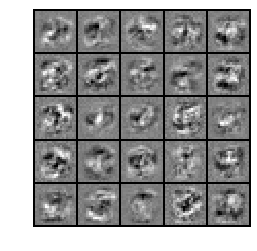

Image of with 25 units each corresponding to one hidden unit in the network.


In [12]:
# ================= Part 9: Visualize Weights =================
#  You can now "visualize" what the neural network is learning by 
#  displaying the hidden units to see what features they are capturing in 
#  the data.

print('Visualizing Neural Network... \n')

displayData(Theta1_opt[:,1:])

print('Image of with 25 units each corresponding to one hidden unit in the network.')

In [13]:
#define function for exercise(s)
def predict(Theta1, Theta2, X):
#PREDICT Predict the label of an input given a trained neural network
#   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
#   trained weights of a neural network (Theta1, Theta2)
 
    #Useful values
    m = X.shape[0]

    #Add ones to the X data matrix
    X = np.column_stack((np.ones((m,1)), X))
    
    #hypothesis calculations
    h1 = sigmoid(np.matrix(X) * np.matrix(Theta1.T))
    h1 = np.column_stack((np.ones((m,1)), h1))
    h2 = sigmoid(np.matrix(h1) * np.matrix(Theta2.T))
    
    #find the indices of the maximum value of each row in the matrix h2
    #then add 1 to get the right label
    p = np.nanargmax(h2, axis=1) + 1
    return p
    #for arrays
    #return np.reshape(p, (-1, 1)) 

# ================= Part 10: Implement Predict =================
#  After training the neural network, we would like to use it to predict
#  the labels. You will now implement the "predict" function to use the
#  neural network to predict the labels of the training set. This lets
#  you compute the training set accuracy

pred = predict(Theta1_opt, Theta2_opt, X)

print('\nTraining Set Accuracy: ', (np.mean(np.equal(pred,y)))*100)
print('Expected Accuracy: 95.3 (approx) \n')


Training Set Accuracy:  96.46000000000001
Expected Accuracy: 95.3 (approx) 



### 3.1 Learning Settings (optional) 
This part of the exercise involves trying out diﬀerent learning settings for the neural network to see how the performance of the neural network varies with the regularization parameter $\lambda$ and number of training steps (the MaxIter option when using an optimizing algorithm).

Neural networks are very powerful models that can form highly complex decision boundaries. Without regularization, it is possible for a neural network to "overﬁt" a training set so that it obtains close to $100\%$ accuracy on the training set but does not as well on new examples that it has not seen before. This can be seen by setting the regularization $\lambda$ to a smaller value and the MaxIter parameter to a higher number of iterations. Changing the learning parameters $\lambda$ and MaxIter changes in the visualizations of the hidden units.


The total cost is 0.2708872938886545
Visualizing Neural Network...

with lambda=0 and maxiter=50


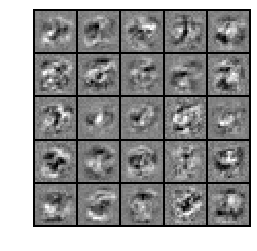

Training Set Accuracy:  96.89999999999999

The total cost is 0.15303227962263918
Visualizing Neural Network...

with lambda=0 and maxiter=75


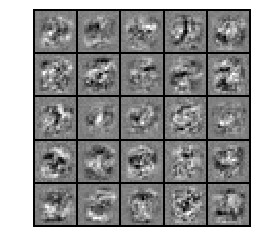

Training Set Accuracy:  98.7

The total cost is 0.05208557154411478
Visualizing Neural Network...

with lambda=0 and maxiter=100


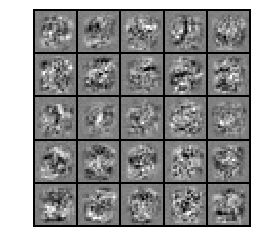

Training Set Accuracy:  99.8


In [14]:
#Try different values of training steps with a smaller regularization 
Lambda = 0
maxiter = np.array([[50, 75, 100]])

for i in range(maxiter.shape[1]):
    
    #minimizing the cost function
    fmin = sp.minimize(fun=nnRegCostFunction, x0=initial_nn_params, 
                            args=(input_layer_size, hidden_layer_size, num_labels, 
                                  X, y, Lambda), method='CG', jac=back_prop, 
                                  options={'maxiter': maxiter[0,i]})
    #total cost
    print('\nThe total cost is', fmin.fun) 
    
    #Obtain Theta1 and Theta2 back from fmin.x
    Theta1_opt = fmin.x[0:hidden_layer_size*(input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1, order='F')
    Theta2_opt = fmin.x[hidden_layer_size*(input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1, order='F')
    
    print('Visualizing Neural Network...\n')
    print('with lambda=%s and maxiter=%s' % (Lambda, maxiter[0,i]))
    displayData(Theta1_opt[:,1:])

    #compute accuracy on our training set
    pred = predict(Theta1_opt, Theta2_opt, X)
    print('Training Set Accuracy: ', (np.mean(np.equal(pred,y)))*100)


The total cost is 0.4416623908775874
Visualizing Neural Network...

with lambda=1 and maxiter=50


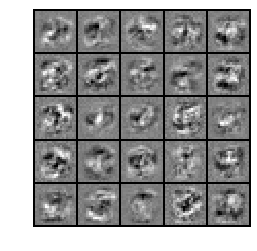

Training Set Accuracy:  96.46000000000001

The total cost is 0.7732800606877641
Visualizing Neural Network...

with lambda=5 and maxiter=50


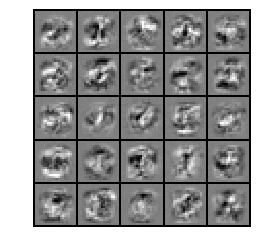

Training Set Accuracy:  94.89999999999999

The total cost is 1.0262590006307486
Visualizing Neural Network...

with lambda=10 and maxiter=50


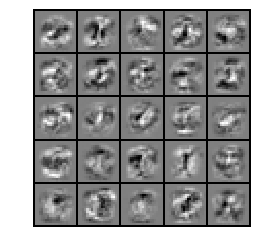

Training Set Accuracy:  93.7


In [15]:
#Try different values of Lambda
Lambda = np.array([[1, 5, 10]])
maxiter = 50

for i in range(Lambda.shape[1]):
    
    #minimizing the cost function
    fmin = sp.minimize(fun=nnRegCostFunction, x0=initial_nn_params, 
                            args=(input_layer_size, hidden_layer_size, num_labels, 
                                  X, y, Lambda[0,i]), method='CG', jac=back_prop, 
                                  options={'maxiter': maxiter})
    #total cost
    print('\nThe total cost is', fmin.fun) 
    
    #Obtain Theta1 and Theta2 back from fmin.x
    Theta1_opt = fmin.x[0:hidden_layer_size*(input_layer_size + 1)].reshape(hidden_layer_size, input_layer_size + 1, order='F')
    Theta2_opt = fmin.x[hidden_layer_size*(input_layer_size + 1):].reshape(num_labels, hidden_layer_size + 1, order='F')
    
    print('Visualizing Neural Network...\n')
    print('with lambda=%s and maxiter=%s' % (Lambda[0,i], maxiter))
    displayData(Theta1_opt[:,1:])

    #compute accuracy on our training set
    pred = predict(Theta1_opt, Theta2_opt, X)
    print('Training Set Accuracy: ', (np.mean(np.equal(pred,y)))*100)